<a href="https://colab.research.google.com/github/AnastasiiaVladimirovna/transcriptomics_homeworks/blob/main/hw11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install scanpy

!pip install --quiet scvi-colab
from scvi_colab import install
install()

import os
os.kill(os.getpid(), 9)

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import scvi
import scanpy as sc

sc.set_figure_params(figsize=(5, 5))

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
# Загрузим датасет
!wget -O PBMC_Satija.h5ad --no-check-certificate "https://docs.google.com/uc?export=download&id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"

--2022-12-26 10:58:14--  https://docs.google.com/uc?export=download&id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.138, 74.125.142.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cfik4mgpt5rsld4b6hc2itetdcghhr98/1672052250000/08626740090461398144/*/1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg?e=download&uuid=7dad3c3c-be24-4943-a25c-b6f70e337878 [following]
--2022-12-26 10:58:15--  https://doc-04-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cfik4mgpt5rsld4b6hc2itetdcghhr98/1672052250000/08626740090461398144/*/1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg?e=download&uuid=7dad3c3c-be24-4943-a25c-b6f70e337878
Resolving doc-04-6s-docs.googleusercontent.com (doc-04-6s-docs.googleusercontent.com)... 74.125.142.132, 

In [3]:
adata = sc.read_h5ad("PBMC_Satija.h5ad")
adata.layers["counts"] = adata.X.copy()


In [4]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="donor"
)

In [5]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata)
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [6]:
model.train(max_epochs=100)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 100/100: 100%|██████████| 100/100 [12:20<00:00,  7.30s/it, loss=404, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [12:20<00:00,  7.40s/it, loss=404, v_num=1]


In [7]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

Сначала сделаем как в семинаре, чтобы сравнивать

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


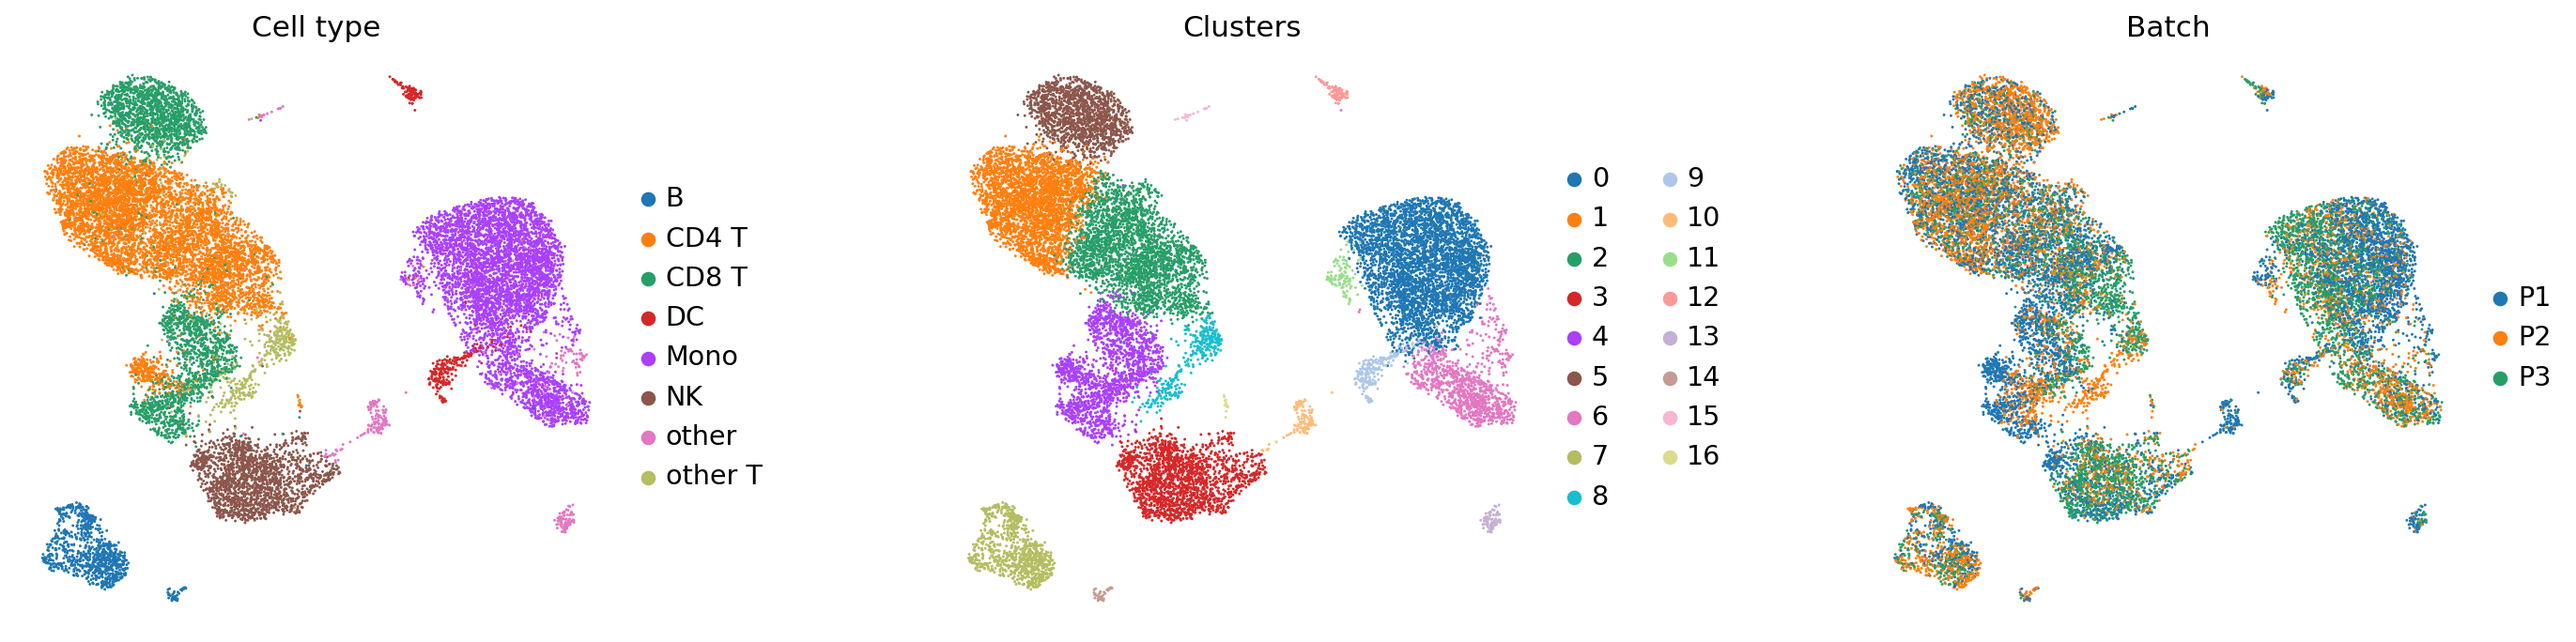

In [8]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

Теперь сделаем так, чтобы дисперсия была не одна и та же у всех типов клеток, а так, чтобы она отличалась между бачами 

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata, dispersion="gene-batch")
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained

In [ ]:
model.train(max_epochs=100)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 100/100: 100%|██████████| 100/100 [12:14<00:00,  7.05s/it, loss=404, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [12:14<00:00,  7.35s/it, loss=404, v_num=1]


In [ ]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)

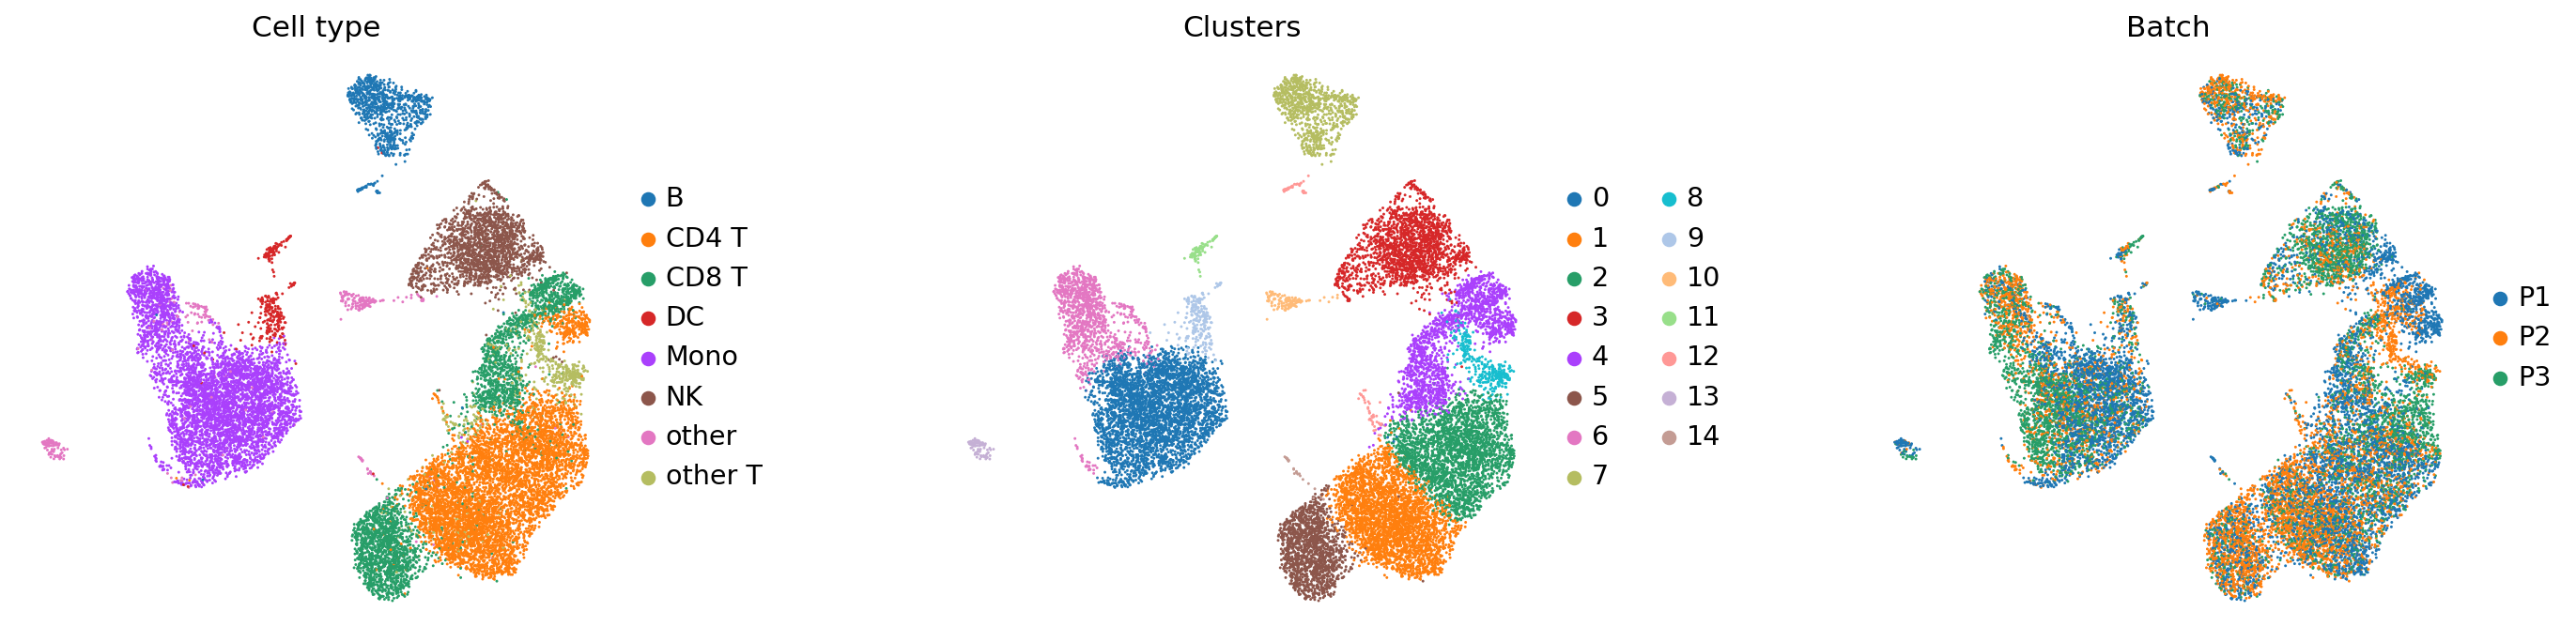

In [ ]:
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

Здесь batch-коррекция также сработала. Тяжело сказать, насколько лучше того, что выше, но точно не хуже

Теперь поменяем распределение на отрицательное биномиальное

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata, gene_likelihood='nb')
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained

In [ ]:
model.train(max_epochs=100)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 100/100: 100%|██████████| 100/100 [09:33<00:00,  5.18s/it, loss=408, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [09:33<00:00,  5.73s/it, loss=408, v_num=1]


In [ ]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)

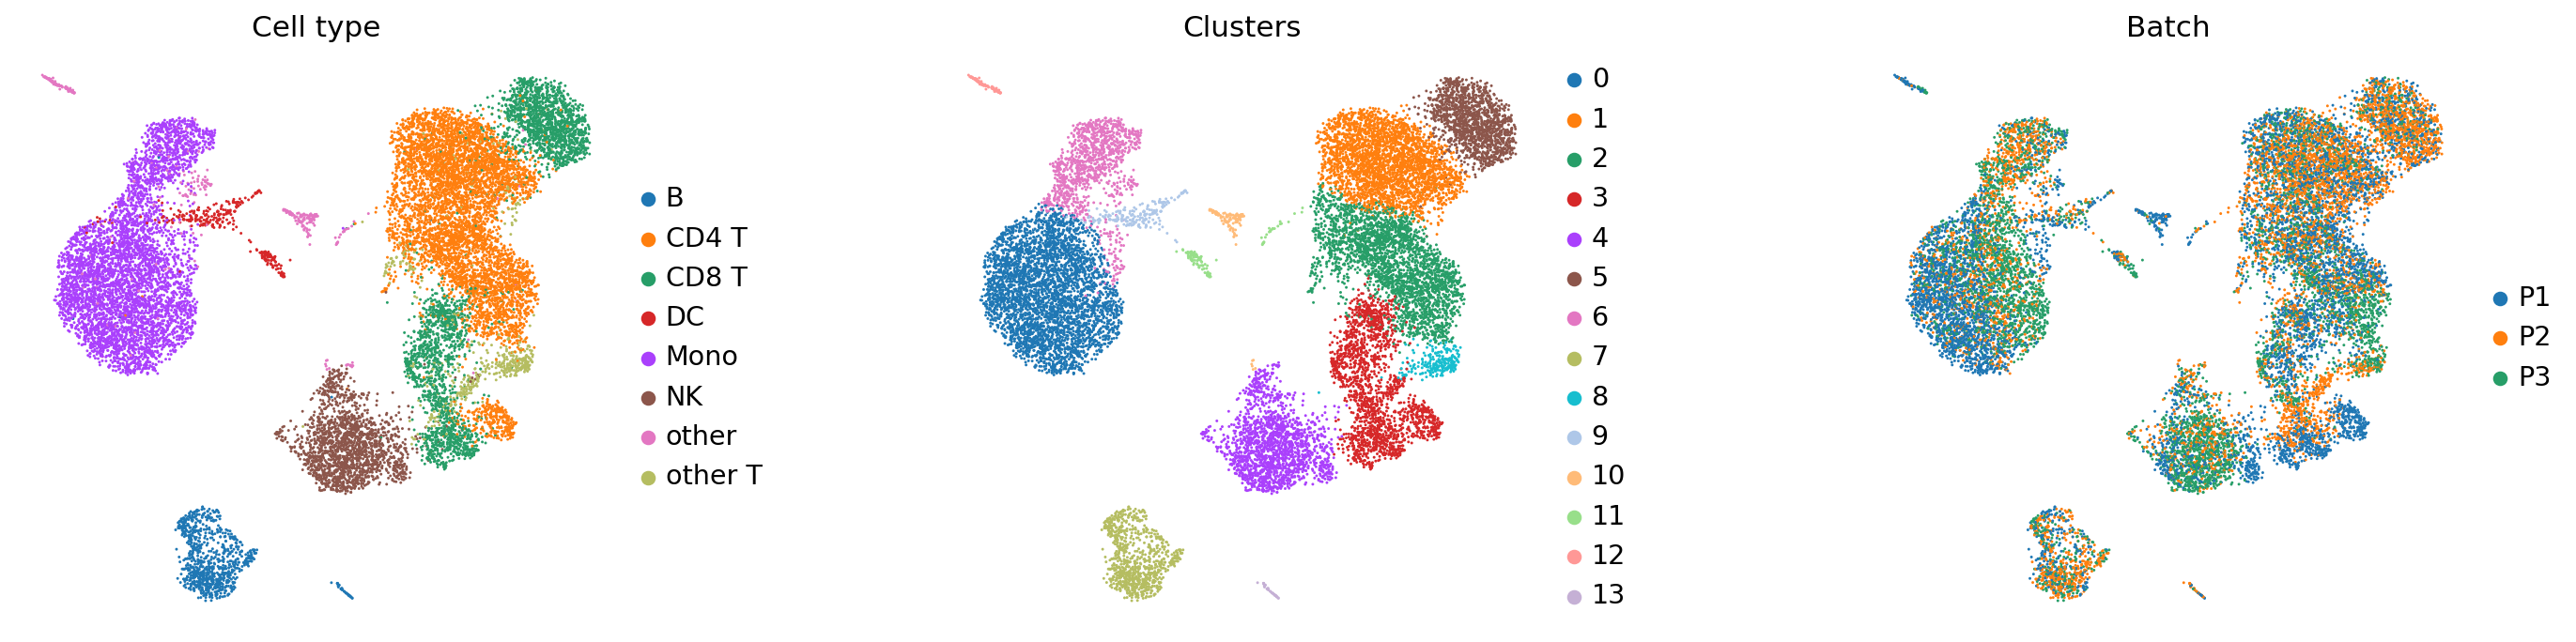

In [ ]:
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

В данном случае batch-коррекция также сработала очень неплохо

Теперь увеличим количество слоев до 10

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata, n_layers=10)

model.train(max_epochs=100)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 100/100: 100%|██████████| 100/100 [15:22<00:00,  8.97s/it, loss=414, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [15:22<00:00,  9.23s/it, loss=414, v_num=1]


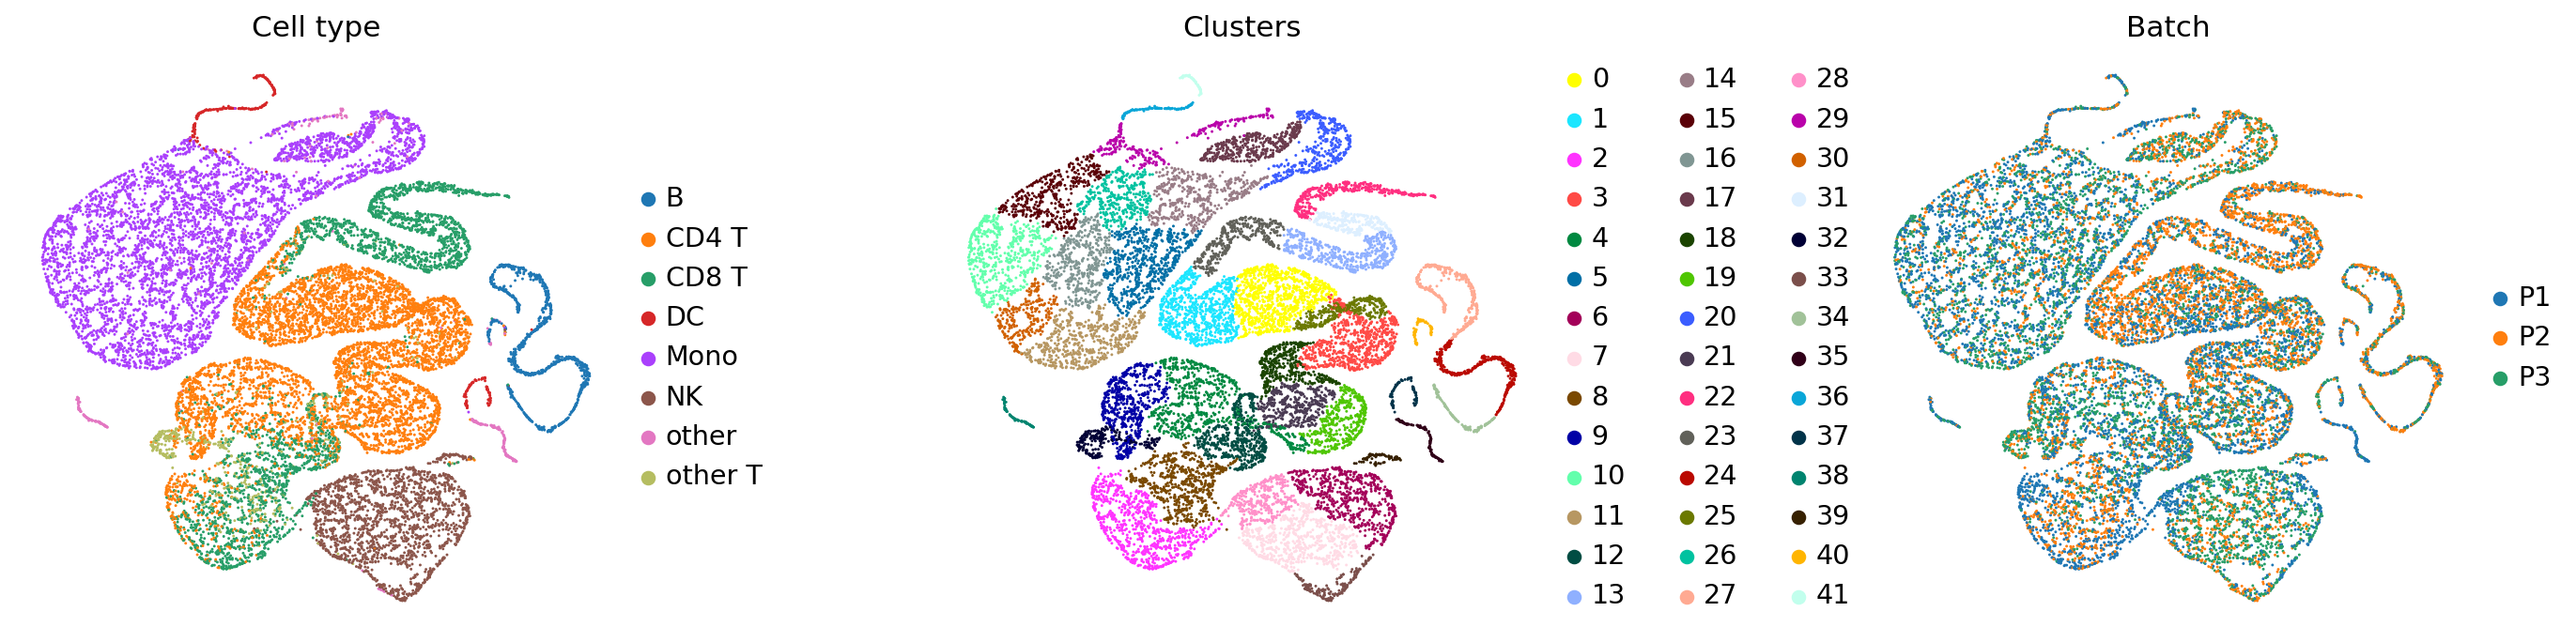

In [ ]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

sc.tl.pca(adata)
# sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
# sc.tl.leiden(adata)
# sc.tl.umap(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

Выглядит страшно, как будто модель перееобучена

Теперь увеличим количество epoch

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="donor"
)
model = scvi.model.SCVI(adata)

model.train(max_epochs=200)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Epoch 200/200: 100%|██████████| 200/200 [22:07<00:00,  6.47s/it, loss=400, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [22:07<00:00,  6.64s/it, loss=400, v_num=1]


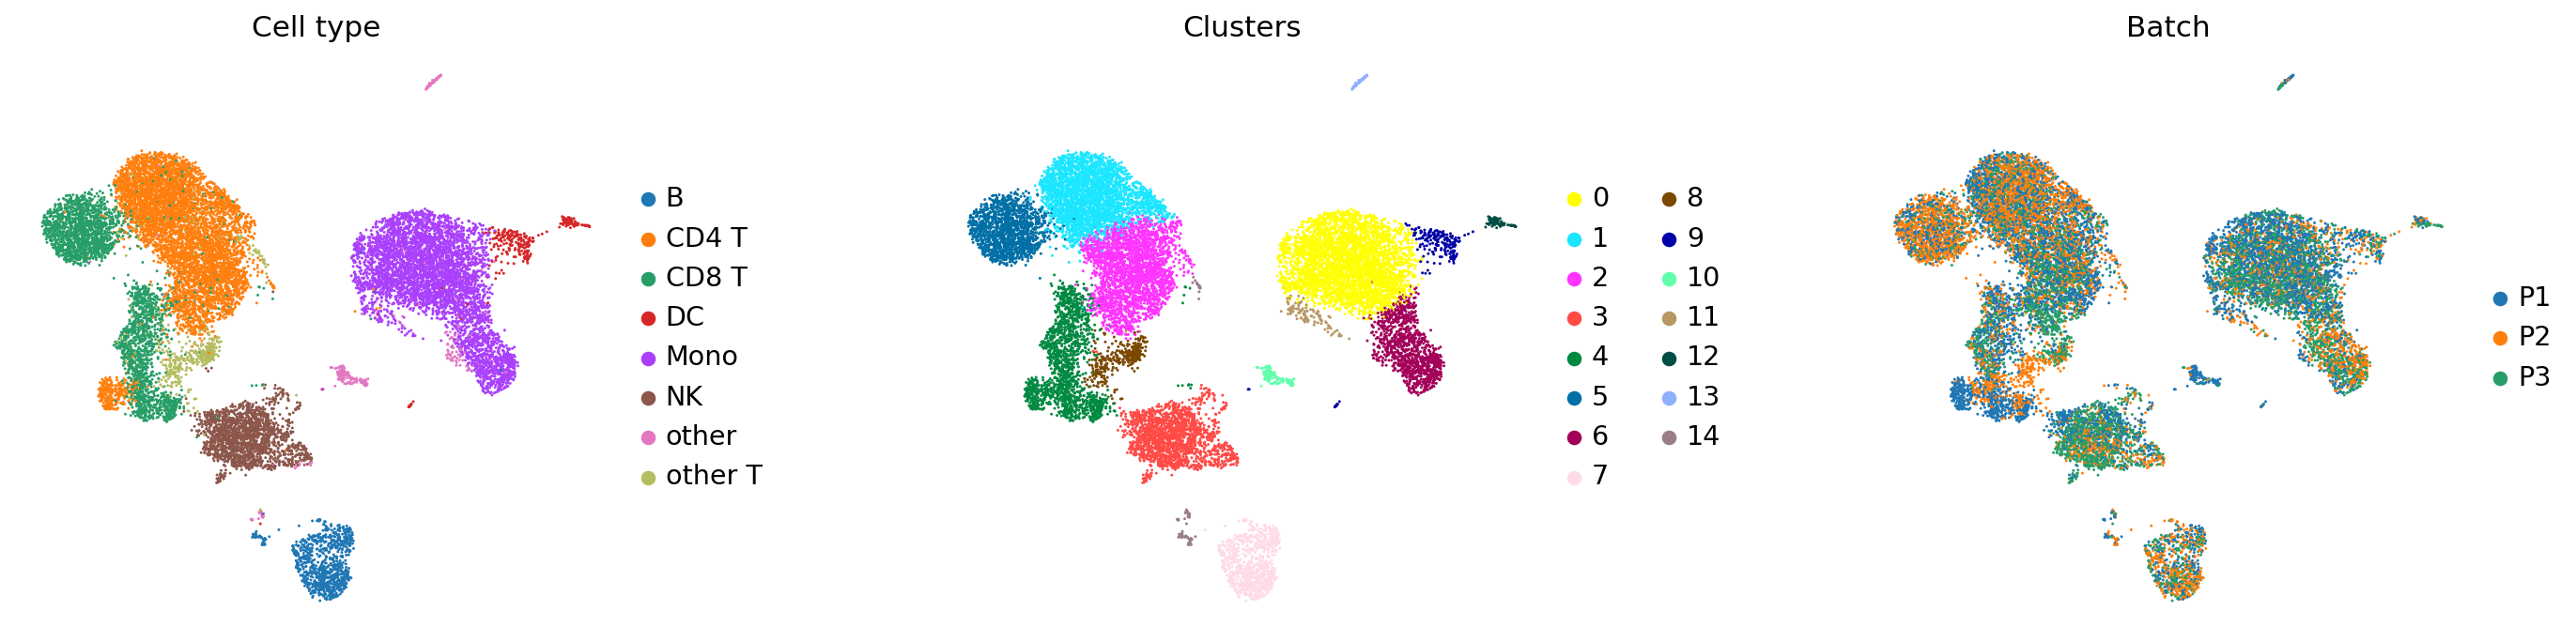

In [ ]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["celltype.l1", "leiden_scVI", "donor"],
           title=["Cell type", "Clusters", "Batch"], wspace=0.4, frameon=False)

Вообще я ожидала, что в данном случае произойдет переобучение, однако я бы сказала, что тут обучение прошло лучше

Таким образом наилучший результат получился при увеличении epoch, однако, так оно конечно долго работает и, насколько я понимаю, если сделать это значение слишком большим, то все станет наоборот плохо. 
Изменение распределения и задание условия разной дисперсии для разных бачей не сильно повлияло на batch-коррекцию, хотя мне казалось, что врое должно было. А вот увеличение значение n_layer ухудшило результат